In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Importing data
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

y = df_train['label']     
X = df_train.drop('label',axis=1)

In [32]:
def scale(data):
    # Scaling the data to be between 0 and 1 since the images we're going to be working with will be grey scale
    scaled_data = data/np.max(data.values)
    return scaled_data

In [33]:
# Scaling data
X = scale(X)
# Reshaping data
X = X.values.reshape(-1,28,28,1)

In [325]:
def plot(data,start):
    """Input: a list of variables containing MNIST data to plot
              what number in the data you want to start at"""

    n = 10
    if start == None:
        start=0
    plt.figure(figsize=(20,len(data)*2))
    # Looping over datasets to compare
    for j in range(len(data)):
        # Looping over numbers in each dataset
        for i in range(start,start+n):
             loc = i-start
             ax = plt.subplot(len(data),n,loc+1+(j*n))
             plt.imshow(data[j][i])
             plt.gray()
             ax.get_xaxis().set_visible(False)
             ax.get_yaxis().set_visible(False)

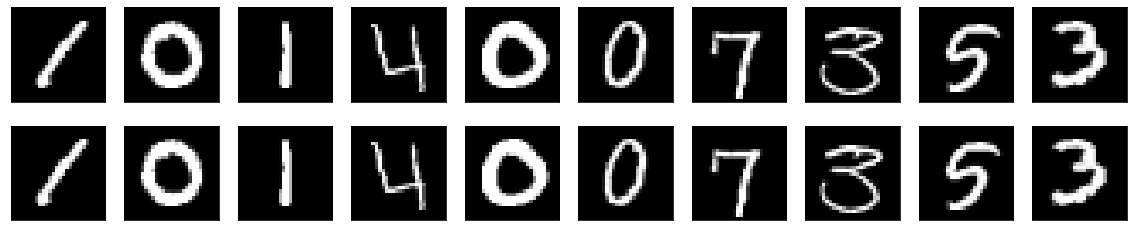

In [312]:
plot([X,X])

In [51]:
def add_noise(data, noise_level):
    """Adding gaussian noise to the data
        Inputs: list of arrays of data
                noise level of gaussian noise you want added"""

    data = data+noise_level*np.random.normal(loc=0,scale=1.0,size=data.shape)

    data = np.clip(data,0,1)

    return data

In [277]:
X_noisy = add_noise(X,noise_level=0.2)

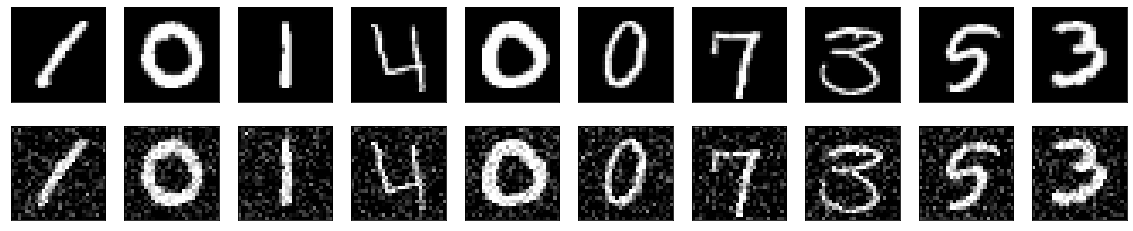

In [278]:
plot([X,X_noisy])

In [301]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,UpSampling2D,Input,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

In [281]:
def AutoEncoderModel():

    """
        blah
    
    """
    input_shape = (28,28,1)
    model = Sequential()
    ##############
    ## Encoding ## 
    ##############
    # First round of downsampling
    model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu',input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    # Second round of downsampling
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    # Third round of downsampling
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    ##############
    ## Decoding ## 
    ##############
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(filters = 16, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

    print (model.summary())

    model.compile(optimizer = 'adam' , loss = "binary_crossentropy")

    return model


In [291]:
def add_model(global_hist,recent_hist,name): 
    """ Input :     Overall history for all models (dataframe)
                    recent model run history (dataframe)
                    name for most recent model (string)
        Output:     Overall history for all models (dataframe) 

    """
    # Removing previous run of this model from model_hist
    global_hist = global_hist[global_hist.model != name]
    recent_hist["model"] = name
    global_hist = pd.concat([global_hist,recent_hist],axis=0)

    return global_hist

In [298]:
# Creating a function to efficiently plot and compare the different models I'm testing
def plot_hist(hist,models,metrics):
    """
    Input: 
        models - list of strings of which models you want to compare, default is all
        metrics - list of strings of which metrics you want to compare"""

    # If empty list passed, all models are compared
    if len(models) == 0: 
        models=list(hist["model"].unique())   
    plt.figure(figsize=(12,6))
    # Looping through all models and metrics and plotting them on the graph with appropriate labels
    for model in models:
        for m in metrics:
            y_plt = hist[(hist["model"]==model)][m].values
            x_plt = range(0,len(y_plt))
            plt.plot(x_plt,y_plt,linewidth=3,label=model+' ('+m+')')
    plt.xlabel('Epochs')
    plt.ylabel(m)
    plt.legend()

In [282]:
from sklearn.model_selection import train_test_split

In [283]:
X_samp = X[0:10000]
X_noisy_samp = X_noisy[0:10000]

In [284]:
X_train_noisy, X_test_noisy ,X_train, X_test = train_test_split(X_noisy_samp,X_samp,test_size=0.2,random_state=101)

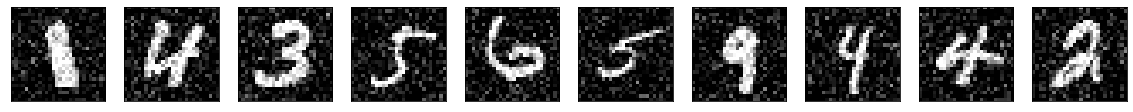

In [285]:
plot([X_train_noisy])

In [304]:
epochs = 100
batch_size=128

In [305]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [309]:
model = AutoEncoderModel()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_243 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 4, 4, 8)         

In [310]:
history = model.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
                    validation_data =(X_test_noisy,X_test),callbacks=callback)

Epoch 1/100
63/63 [==============================] - 8s 131ms/step - loss: 0.4999 - val_loss: 0.3541
Epoch 2/100
63/63 [==============================] - 8s 125ms/step - loss: 0.2698 - val_loss: 0.2343
Epoch 3/100
63/63 [==============================] - 8s 125ms/step - loss: 0.2168 - val_loss: 0.2047
Epoch 4/100
63/63 [==============================] - 8s 125ms/step - loss: 0.1959 - val_loss: 0.1893
Epoch 5/100
63/63 [==============================] - 8s 128ms/step - loss: 0.1829 - val_loss: 0.1781
Epoch 6/100
63/63 [==============================] - 8s 124ms/step - loss: 0.1733 - val_loss: 0.1698
Epoch 7/100
63/63 [==============================] - 8s 125ms/step - loss: 0.1662 - val_loss: 0.1635
Epoch 8/100
63/63 [==============================] - 8s 126ms/step - loss: 0.1604 - val_loss: 0.1589
Epoch 9/100
63/63 [==============================] - 8s 124ms/step - loss: 0.1559 - val_loss: 0.1546
Epoch 10/100
63/63 [==============================] - 8s 129ms/step - loss: 0.1524 - val_lo

In [313]:
decoded_img = model.predict(X_test)

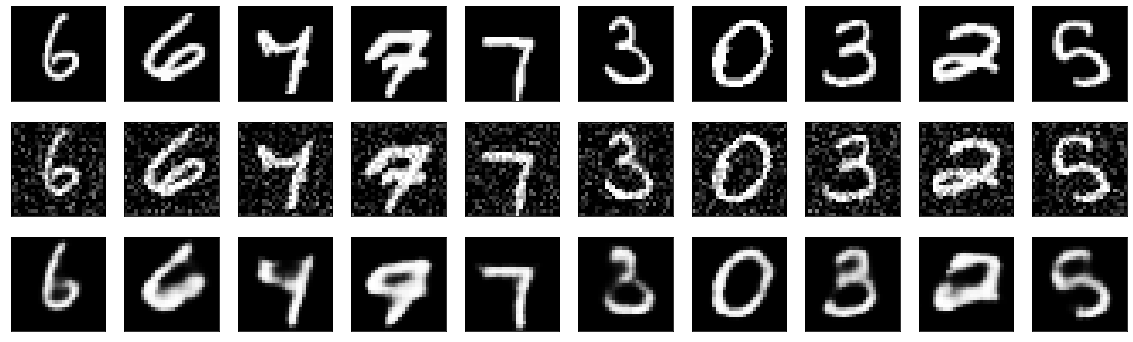

In [326]:
plot([X_test,X_test_noisy,decoded_img],500)

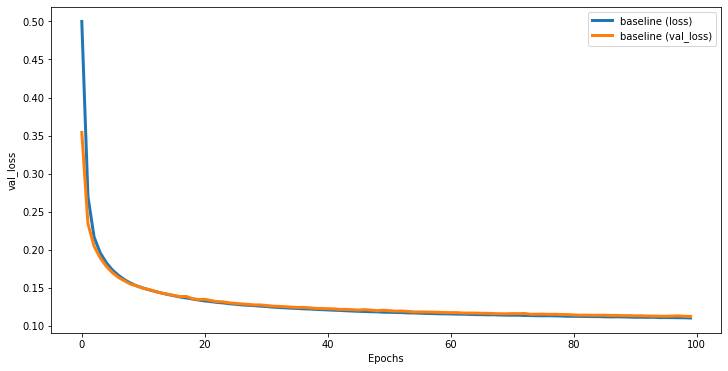

In [315]:
hist = pd.DataFrame(history.history)
hist["model"]='baseline'
plot_hist(hist,models=['baseline'],metrics=['loss','val_loss'])

In [329]:
from tensorflow.keras.utils import plot_model
import os

In [334]:
#os.system('mkdir tmp')
dot_img_file = './tmp/model_1.png'


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [335]:
plot_model(model, to_file=dot_img_file, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
